На базе баскетбольных матчей добейтесь средней абсолютной ошибки 17 и менее очков.

# Задание  

In [ ]:
# Загрузка из google облака
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)

# Библиотека для работы с базами
import pandas as pd
df = pd.read_csv('basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) # Загружаем базу
df.head()

,TOTAL,info,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
0,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,0.0,1,1.0,30,81,90.0
1,"100,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,1,1.0,45,81,105.0
2,"99,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,0,81,120.0
3,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,30,81,150.0
4,"95,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,3,3.0,0,81,180.0


Извлекаем текстовые данные из колонки `info` таблицы, помещаем в переменную `data_text`. Выводим длину списка:

In [ ]:
data_text = df['info'].values #

len(data_text) #

52450

Задаем максимальное кол-во слов в словаре, помещаем в переменную все символы, которые хотим вычистить из текста.

 Токенизируем текстовые данные:

In [ ]:
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

maxWordsCount = 5000

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount,
                       filters=sim_for_del,
                       lower=True,
                       split=' ',
                       oov_token='unknown',
                       char_level=False)

tokenizer.fit_on_texts(data_text)

In [ ]:
# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

Преобразуем данные в numpy, подготовим наборы для обучения:

In [ ]:
# Библиотека работы с массивами
import numpy as np

xTrain = np.array(df[['Ком. 1','Ком. 2', 'Минута', 'Секунда','ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xBOW_text.shape)

(52450, 5)
(52450,)
(52450, 5000)


*Исполнять код отсюда

In [ ]:
# Функция по проверке ошибки

def check_MAE_predictl_DubbleInput (model,
                                    x_data,
                                    x_data_text,
                                    y_data_not_scaled,
                                    plot=False):

  mae = 0 # Инициализируем начальное значение ошибки
  y_pred = (model.predict([x_data,x_data_text])).squeeze()

  for n in range (0,len(x_data)):
    mae += abs(y_data_not_scaled[n] - y_pred[n]) # Увеличиваем значение ошибки для текущего элемента
  mae /= len(x_data) # Считаем среднее значение
  print('\nСреднаяя абслолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры'.format(mae, (mae/y_data_not_scaled.mean(axis=0))*100,len(x_data)))

  if plot:
     plt.scatter(y_data_not_scaled, y_pred)
     plt.xlabel('Правильные значение')
     plt.ylabel('Предсказания')
     plt.axis('equal')
     plt.xlim(plt.xlim())
     plt.ylim(plt.ylim())
     plt.plot([0, 250], [0, 250])
     plt.show()

In [ ]:
# начальная
def on_epoch_end_custom(epoch, logs=None):
    check_MAE_predictl_DubbleInput(model_final_scaled,xTrain_scaled,xBOW_text,yTrain,plot=True)

In [ ]:
# ваше решение

# Библиотеки которые понадобятся
from tensorflow.keras.layers import Dropout, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt

# Нормирование данных
xTrain = xTrain[xTrain.sum(axis=1) != 0]
xTrain_reshaped = []
for col in xTrain.T:
    xTrain_reshaped.append(col.reshape(-1, 1))
xTrain_reshaped = np.concatenate(xTrain_reshaped, axis=1)
x_scaler = StandardScaler()
x_scaler.fit(xTrain_reshaped)
xTrain_scaled = x_scaler.transform(xTrain_reshaped)


In [ ]:
# Построение модели

input1 = Input((xTrain_scaled.shape[1],))
input2 = Input((xBOW_text.shape[1],))

x1 = input1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(500, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)
x1 = Dropout(0.3)(x1)

x2 = input2
x2 = Dense(128, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dense(100, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1,x2])
x = Dense(100, activation="LeakyReLU")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)

model_final_scaled = Model((input1, input2), x)

model_final_scaled.compile(optimizer=Adam(learning_rate=1e-3), loss='mae', metrics=['mae'])

history = model_final_scaled.fit([xTrain_scaled, xBOW_text],
                        yTrain,
                        batch_size=128,
                        epochs=50,
                        validation_split=0.15,
                        verbose=1)


Epoch 1/50
349/349 [==============================] - 10s 8ms/step - loss: 27.1334 - mae: 27.1334 - val_loss: 19.5028 - val_mae: 19.5028
Epoch 2/50
349/349 [==============================] - 2s 6ms/step - loss: 15.7533 - mae: 15.7533 - val_loss: 19.3429 - val_mae: 19.3429
Epoch 3/50
349/349 [==============================] - 2s 7ms/step - loss: 15.3484 - mae: 15.3484 - val_loss: 18.3371 - val_mae: 18.3371
Epoch 4/50
349/349 [==============================] - 3s 7ms/step - loss: 15.2789 - mae: 15.2789 - val_loss: 17.1859 - val_mae: 17.1859
Epoch 5/50
349/349 [==============================] - 2s 6ms/step - loss: 15.1256 - mae: 15.1256 - val_loss: 17.0953 - val_mae: 17.0953
Epoch 6/50
349/349 [==============================] - 2s 6ms/step - loss: 15.0452 - mae: 15.0452 - val_loss: 16.3788 - val_mae: 16.3788
Epoch 7/50
349/349 [==============================] - 2s 6ms/step - loss: 15.0179 - mae: 15.0179 - val_loss: 16.6001 - val_mae: 16.6001
Epoch 8/50
349/349 [===========================

1640/1640 [==============================] - 3s 2ms/step

Среднаяя абслолютная ошибка 6.593 очков это 4.348% от общей выборки в 52450 игры


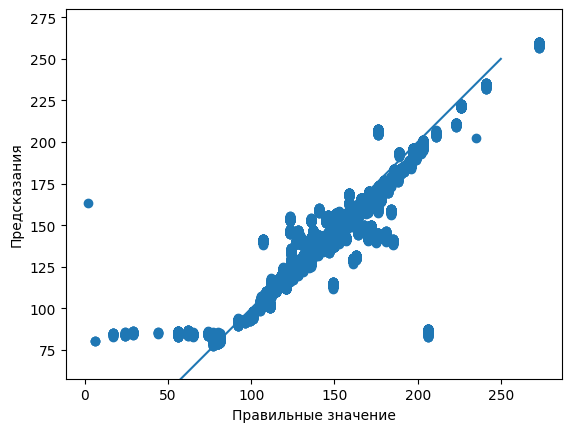

In [ ]:
# Тображение средней абсолютной ошибки
check_MAE_predictl_DubbleInput(model_final_scaled,xTrain_scaled,xBOW_text,yTrain,plot=True)

# Последние исследования

In [ ]:
# Полный код сложной модели для сравнения

import gdown
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dropout, Dense, SimpleRNN, LSTM, GRU, Bidirectional, MaxPooling1D, GlobalMaxPooling1D, Reshape, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import LambdaCallback

# Загрузка данных
url = 'https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv'
gdown.download(url, 'basketball.csv', quiet=False)

# Загрузка и предобработка данных
df = pd.read_csv('basketball.csv', encoding='cp1251', sep=';', header=0, index_col=0)
data_text = df['info'].values

maxWordsCount = 5000

sim_for_del = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters=sim_for_del,
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(data_text)
Sequences = tokenizer.texts_to_sequences(data_text)
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

xTrain = np.array(df[['Ком. 1', 'Ком. 2', 'Минута', 'Секунда', 'ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))

# Масштабирование данных
# yTrain_reshaped = yTrain.reshape(-1, 1)
# y_scaler = StandardScaler()
# y_scaler.fit(yTrain_reshaped)
# yTrain_scaled = y_scaler.transform(yTrain_reshaped)

xTrain = xTrain[xTrain.sum(axis=1) != 0]
xTrain_reshaped = xTrain.reshape((xTrain.shape[0], xTrain.shape[1], 1))
x_scaler = StandardScaler()
# Масштабируем данные по последнему измерению
xTrain_scaled = x_scaler.fit_transform(xTrain_reshaped[:, :, 0])

# scaler = MinMaxScaler()
# xBOW_text_scaled = scaler.fit_transform(xBOW_text)

# Определение модели - первая ветка
input1 = Input(shape=(xTrain_scaled.shape[1], 1))
input2 = Input(shape=(xBOW_text.shape[1],))

x1 = Conv1D(1, kernel_size=3, activation="relu", padding='same')(input1)
x1 = Flatten()(x1)
x1 = Dropout(0.3)(x1)

# Используйте input2 для SimpleRNN
x2 = Reshape((-1, 1))(input2)  # Добавляем измерение времени
x2 = SimpleRNN(64, activation='relu', return_sequences=True)(x2)
x2 = LSTM(128, return_sequences=True)(x2)
x2 = GRU(64, activation='relu', return_sequences=True)(x2)
x2 = Bidirectional(LSTM(64, return_sequences=True))(x2)
x2 = GlobalMaxPooling1D()(x2)

# Выравнивание входов
x1_aligned = Dense(50, activation='relu')(x1)
x2_aligned = Dense(50, activation='relu')(x2)

# Объединение обеих веток
x = concatenate([x1_aligned, x2_aligned])

# Вторая ветка
x3 = Flatten()(input1)
x3 = Dense(50, activation="relu")(x3)
x3 = Dense(500, activation="tanh")(x3)
x3 = Dense(50, activation="relu")(x3)
x3 = Dropout(0.3)(x2)

# Объединение обеих веток
x = concatenate([x, x3])

# Остаток модели
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
x = Dense(128, activation="LeakyReLU")(x)
# x = Dense(10, activation="LeakyReLU")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dense(1, activation='linear')(x)

model_fin = Model([input1, input2], x)

model_fin.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

# Обучение модели
history = model_fin.fit([xTrain_scaled, xBOW_text],
                        yTrain,
                        batch_size=64,
                        epochs=5,
                        validation_split=0.15,
                        verbose=1)



Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv
To: /content/basketball.csv
100%|██████████| 6.21M/6.21M [00:01<00:00, 6.07MB/s]


Epoch 1/5
 28/697 [>.............................] - ETA: 8:31:55 - loss: nan - mae: nan

KeyboardInterrupt: 

In [ ]:
# для сравнения
def on_epoch_end_custom(epoch, logs=None):
    check_MAE_predictl_DubbleInput(model_fin,xTrain,xBOW_text_scaled,yTrain,plot=True)

1640/1640 [==============================] - 3s 2ms/step
Среднаяя абслолютная ошибка 151.630 очков это 100.003% от общей выборки в 52450 игры


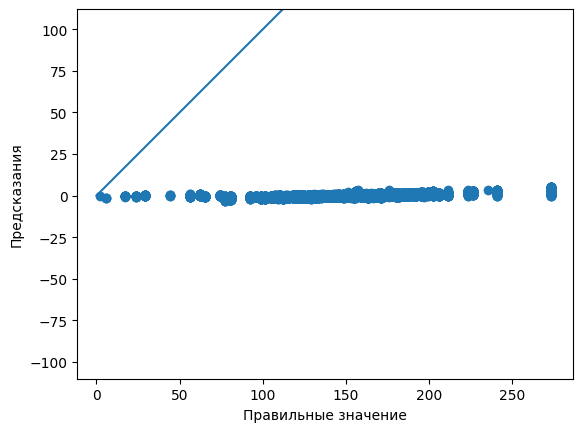

In [ ]:
#  для сравнения
import matplotlib.pyplot as plt

check_MAE_predictl_DubbleInput(model_fin,xTrain_scaled,xBOW_text,yTrain,plot=True)

In [ ]:
#  МАЕ по функции из учебного ноутбука

def eval(model, xTrain, xBOW_text_scaled, yTrain, y_scaler=None, n=5, limit=300):
    plt.style.use('default')

    input_data = [xTrain, xBOW_text_scaled]
    pred = model.predict(input_data)
    if y_scaler:
        pred = y_scaler.inverse_transform(pred) #yTrain

    # print('Первые пять примеров:')
    # for i in range(n):
    #     print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
    #                                                                                                 pred[i, 0],
    #                                                                                                 abs(yTrain[i] - pred[i, 0])))

    start_index = len(yTrain) - 5
    print('Последние пять примеров:')
    for i in range(start_index, len(yTrain)):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))
                                                                                                    # abs(yTrain[i] - pred[i, 0])))

    print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(yTrain, pred)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

# Пример использования
eval(model_fin, xTrain_scaled, xBOW_text_scaled, yTrain_scaled, y_scaler)


1640/1640 [==============================] - 8s 5ms/step


NameError: name 'mean_absolute_error' is not defined

1640/1640 [==============================] - 8s 5ms/step
Последние пять примеров:
Реальное значение:   0.74  Предсказанное значение: 143.56  Разница: 142.82
Реальное значение:   0.74  Предсказанное значение: 143.56  Разница: 142.82
Реальное значение:   0.74  Предсказанное значение: 143.56  Разница: 142.82
Реальное значение:   0.74  Предсказанное значение: 143.56  Разница: 142.82
Реальное значение:   0.74  Предсказанное значение: 143.56  Разница: 142.82

Средняя абсолютная ошибка: 153.35855715479818 



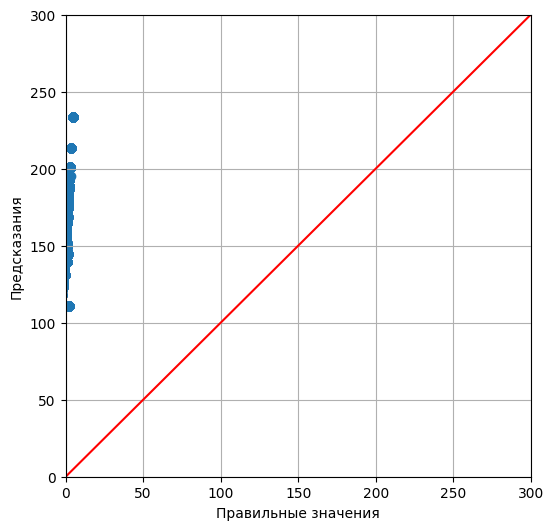

In [ ]:
#  МАЕ по функции из учебного ноутбука
from sklearn.metrics import mean_absolute_error

def eval(model, xTrain, xBOW_text_scaled, yTrain, y_scaler, n=5, limit=300):
    plt.style.use('default')

    input_data = [xTrain, xBOW_text_scaled]
    pred = model.predict(input_data)
    if y_scaler:
        pred = y_scaler.inverse_transform(pred)

    start_index = max(0, len(yTrain) - n)
    print('Последние пять примеров:')
    for i in range(start_index, len(yTrain)):
        real_value = np.nditer([yTrain[i]])[0].item() if isinstance(yTrain[i], np.ndarray) else yTrain[i]
        predicted_value = np.nditer([pred[i, 0]])[0].item() if isinstance(pred[i, 0], np.ndarray) else pred[i, 0]
        diff = abs(real_value - predicted_value)
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(real_value,
                                                                                                    predicted_value,
                                                                                                    diff))
    print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(yTrain, pred)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

# Пример использования
eval(model_fin, xTrain_scaled, xBOW_text_scaled, yTrain_scaled, y_scaler)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Предобработка данных
scaler = MinMaxScaler()
xTrain_scaled = scaler.fit_transform(xTrain_scaled)
xTrain_scaled, xVal_scaled, yTrain_scaled, yVal_scaled = train_test_split(xTrain_scaled, yTrain_scaled, test_size=0.15, random_state=42)

# Архитектура модели
from tensorflow.keras.layers import Reshape

input1 = Input(shape=(xTrain_scaled.shape[1],))
x1 = Dense(128, activation="relu", kernel_initializer=glorot_uniform(seed=42), kernel_regularizer=l2(0.01))(input1)
x1 = Dropout(0.3)(x1)
x1 = Dense(64, activation="relu", kernel_initializer=glorot_uniform(seed=42), kernel_regularizer=l2(0.01))(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(32, activation="relu", kernel_initializer=glorot_uniform(seed=42), kernel_regularizer=l2(0.01))(x1)
x1 = Dropout(0.3)(x1)

input2 = Input(shape=(1, xBOW_text_scaled.shape[1]))
x2 = Reshape((xBOW_text_scaled.shape[1], 1))(input2)
x2 = LSTM(128, activation="tanh", return_sequences=True, kernel_initializer=glorot_uniform(seed=42), recurrent_regularizer=l2(0.01))(x2)
x2 = LSTM(64, activation="tanh", kernel_initializer=glorot_uniform(seed=42), recurrent_regularizer=l2(0.01))(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])
x = GlobalAveragePooling2D()(x)
x = Dense(15, activation="relu", kernel_initializer=glorot_uniform(seed=42), kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='linear', kernel_initializer=glorot_uniform(seed=42))(x)

model_final_scaled = Model(inputs=[input1, input2], outputs=x)

model_final_scaled.compile(optimizer=Adam(learning_rate=1e-3), loss='mae', metrics=['mae'])

# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_final_scaled.fit([xTrain_scaled, xBOW_text_scaled], yTrain_scaled, batch_size=256, epochs=100, validation_data=([xVal_scaled, xBOW_text_scaled], yVal_scaled), callbacks=[early_stopping], verbose=1)

# Проверка точности предсказаний
yPred = model_final_scaled.predict([xTest_scaled, xBOW_text_scaled])
yPred = scaler.inverse_transform(yPred)
mae = mean_absolute_error(yTest_scaled, yPred)
print(f"MAE: {mae:.3f}")

ValueError: Input 0 of layer "global_average_pooling2d" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 96)

In [ ]:
# вариант другой модели, для сравнения

from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, MaxPooling1D, GlobalMaxPooling1D, Reshape


from tensorflow.keras.layers import Input, Conv1D, Flatten, Dropout, Dense, SimpleRNN, LSTM, GRU, Bidirectional, MaxPooling1D, GlobalMaxPooling1D, Reshape, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Определение модели - первая ветка
input1 = Input(shape=(1, xTrain_scaled.shape[2]))
input2 = Input(shape=(xBOW_text.shape[1],))

x1 = Conv1D(1, kernel_size=3, activation="relu", padding='same')(input1)
x1 = Flatten()(x1)
x1 = Dropout(0.3)(x1)

# Используйте input2 для SimpleRNN
x2 = Reshape((-1, 1))(input2)  # Добавляем измерение времени
x2 = SimpleRNN(64, activation='relu', return_sequences=True)(x2)
x2 = LSTM(128, return_sequences=True)(x2)
x2 = GRU(64, activation='relu', return_sequences=True)(x2)
x2 = Bidirectional(LSTM(64, return_sequences=True))(x2)
x2 = GlobalMaxPooling1D()(x2)

# Выравнивание входов
x1_aligned = Dense(100, activation='relu')(x1)
x2_aligned = Dense(100, activation='relu')(x2)

# Объединение обеих веток
x = concatenate([x1_aligned, x2_aligned])

# Вторая ветка
x3 = Flatten()(input1)
x3 = Dense(128, activation="relu")(x3)
# x3 = Dense(1000, activation="tanh")(x3)
x3 = Dense(100, activation="relu")(x3)
x3 = Dropout(0.3)(x3)

# Объединение обеих веток
x = concatenate([x, x3])

# Остаток модели
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dense(1, activation='linear')(x)

model_fin = Model([input1, input2], x)

model_fin.compile(optimizer=Adam(learning_rate=1e-3), loss='mae', metrics=['mae'])

# Обучение модели
history = model_fin.fit([xTrain_scaled, xBOW_text],
                        yTrain,
                        batch_size=128,
                        epochs=5,
                        validation_split=0.15,
                        verbose=1)


# Исследования

In [ ]:
def check_MAE_predictl_DubbleInput (model,
                                    x_data,
                                    x_data_text,
                                    y_data_not_scaled,
                                    plot=False):

    y_pred = model.predict([x_data, x_data_text]).squeeze()

    mae = mean_absolute_error(y_data_not_scaled, y_pred)

    print('Средняя абсолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры'.format(mae, (mae/y_data_not_scaled.mean(axis=0))*100,len(x_data)))

    if plot:
        plt.scatter(y_data_not_scaled, y_pred)
        plt.xlabel('Правильные значение')
        plt.ylabel('Предсказания')
        plt.axis('equal')
        plt.xlim(plt.xlim())
        plt.ylim(plt.ylim())
        plt.plot([0, 250], [0, 250])
        plt.show()

In [ ]:
def on_epoch_end_custom(epoch, logs=None):
    check_MAE_predictl_DubbleInput(model_fin, xTrain, xBOW_text_scaled, yTrain, plot=True)
    mae_epoch = logs['val_mae']  # Получаем значение MAE на текущей эпохе
    mae_history.append(mae_epoch)  # Добавляем в список

# Создаем пустой список для сохранения значений MAE
mae_history = []

# Добавляем обработчик на окончание эпохи
history_callback = model_fin.fit([xTrain, xBOW_text_scaled],
                                yTrain_scaled,
                                batch_size=256,
                                epochs=50,
                                validation_split=0.15,
                                verbose=1,
                                callbacks=[on_epoch_end_custom])

# Построим график средней функции ошибки по эпохам
plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.xlabel('Эпоха')
plt.ylabel('Средняя абсолютная ошибка (MAE)')
plt.title('График MAE по эпохам')
plt.show()


AttributeError: 'function' object has no attribute 'set_model'

In [ ]:
# ...

# history = model_fin.fit([xTrain, xBOW_text_scaled],
#                         yTrain_scaled,
#                         batch_size=256,
#                         epochs=50,
#                         validation_split=0.15,
#                         verbose=1,
#                         callbacks=[LambdaCallback(on_epoch_end=on_epoch_end_custom)])

# Добавленный код
train_mae_final = history.history['mae'][-1]
val_mae_final = history.history['val_mae'][-1]

print(f'Final Training MAE: {train_mae_final:.3f}')
print(f'Final Validation MAE: {val_mae_final:.3f}')

# ...


In [ ]:
def eval(model, xTrain, xBOW_text_scaled, yTrain, y_scaler=None, n=5, limit=300):
    plt.style.use('default')

    input_data = [xTrain, xBOW_text_scaled]
    pred = model.predict(input_data)
    if y_scaler:
        pred = y_scaler.inverse_transform(pred)

    print('Первые пять примеров:')
    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))

    start_index = len(yTrain) - 5
    print('Последние пять примеров:')
    for i in range(start_index, len(yTrain)):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))


    start_index = len(yTrain) - 2500
    print('Срез половины примеров:')
    for i in range(start_index, len(yTrain)):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))


    print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(yTrain, pred)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

# Пример использования
eval(model_fin, xTrain, xBOW_text_scaled, yTrain, y_scaler)

In [ ]:
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)

import pandas as pd
df = pd.read_csv('basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) # Загружаем базу
df.head()

data_text = df['info'].values #

from tensorflow.keras.preprocessing.text import Tokenizer

maxWordsCount = 5000

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount,
                       filters=sim_for_del,
                       lower=True,
                       split=' ',
                       oov_token='unknown',
                       char_level=False)

tokenizer.fit_on_texts(data_text)

Sequences = tokenizer.texts_to_sequences(data_text)
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

import numpy as np

xTrain = np.array(df[['Ком. 1','Ком. 2', 'Минута', 'Секунда','ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))



from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

yTrain_reshaped = yTrain.reshape(-1, 1)
y_scaler = StandardScaler()
y_scaler.fit(yTrain_reshaped)
yTrain_scaled = y_scaler.transform(yTrain_reshaped)

scaler = MinMaxScaler()
xBOW_text_scaled = scaler.fit_transform(xBOW_text)


model_simple3 = Sequential()
model_simple3.add(BatchNormalization(input_dim=xBOW_text_scaled.shape[1]))
model_simple3.add(Dense(128, activation='relu'))
model_simple3.add(Dense(1000, activation='tanh'))
model_simple3.add(Dense(100, activation='relu'))
model_simple3.add(Dense(1, activation='linear'))

model_simple3.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

model_fin = model_simple3
history = model_fin.fit(xBOW_text_scaled,
                        yTrain_scaled,
                        batch_size=256,
                        epochs=1,
                        validation_split=0.15,
                        verbose=1)

175/175 [==============================] - 11s 56ms/step - loss: 0.8066 - mae: 0.6255 - val_loss: 0.7284 - val_mae: 0.7070


In [ ]:
# Освобождение памяти от ненужных более объектов
del data_text, tokenizer, df

In [ ]:
def check_MAE_predictl_DubbleInput (model,
                                    x_data,
                                    x_data_text,
                                    y_data_not_scaled,
                                    plot=False):

  mae = 0 # Инициализируем начальное значение ошибки
  y_pred = (model.predict([x_data,x_data_text])).squeeze()

  for n in range (0,len(x_data)):
    mae += abs(y_data_not_scaled[n] - y_pred[n]) # Увеличиваем значение ошибки для текущего элемента
  mae /= len(x_data) # Считаем среднее значение
  print('Среднаяя абслолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры'.format(mae, (mae/y_data_not_scaled.mean(axis=0))*100,len(x_data)))

  if plot:
     plt.scatter(y_data_not_scaled, y_pred)
     plt.xlabel('Правильные значение')
     plt.ylabel('Предсказания')
     plt.axis('equal')
     plt.xlim(plt.xlim())
     plt.ylim(plt.ylim())
     plt.plot([0, 250], [0, 250])
     plt.show()

def on_epoch_end_custom(epoch, logs=None):
    check_MAE_predictl_DubbleInput(model_fin, xBOW_text, yTrain, plot=True)
    # check_MAE_predictl_DubbleInput(model_fin, xBOW_text, xBOW_text_scaled, yTrain_scaled, plot=True)


# check_MAE_predictl_DubbleInput(model_fin, xBOW_text, yTrain, plot=True)
check_MAE_predictl_DubbleInput(model_fin, [xBOW_text, xBOW_text_scaled], yTrain_scaled, plot=True)



TypeError: check_MAE_predictl_DubbleInput() missing 1 required positional argument: 'y_data_not_scaled'

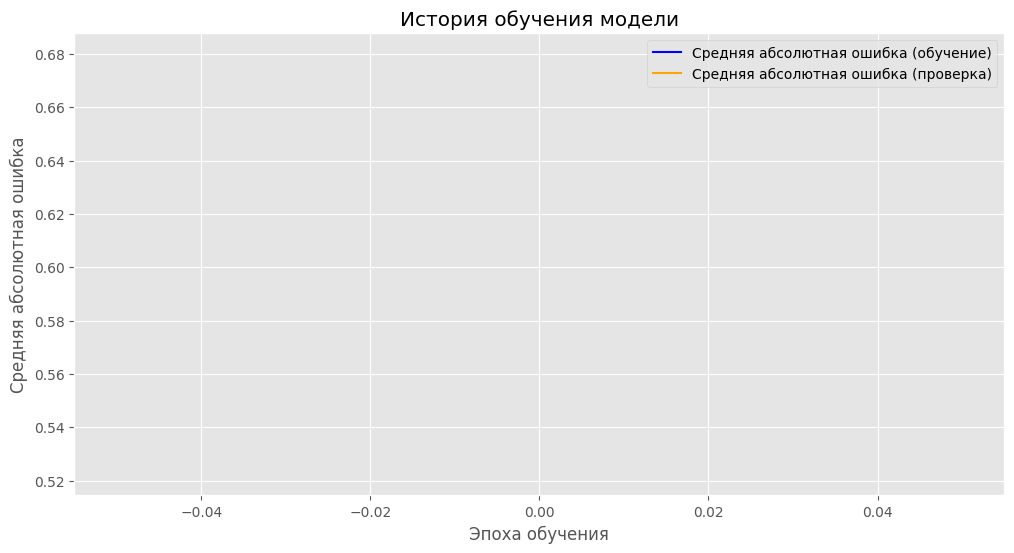

In [ ]:
def plot_history(history):
    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Средняя абсолютная ошибка (обучение)', color='blue')
    plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка (проверка)', color='orange')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.title('История обучения модели')
    plt.legend()
    plt.show()

plot_history(history)

1640/1640 [==============================] - 6s 4ms/step

Средняя абсолютная ошибка: 6.604500620708338 

Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12


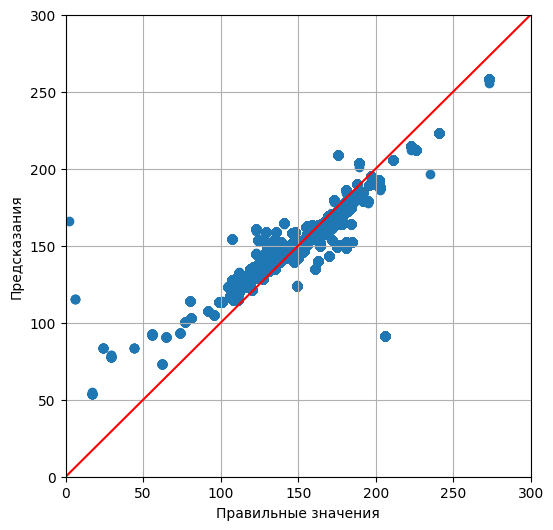

In [ ]:
def eval(model, xTrain, yTrain, y_scaler = None, n = 5, limit = 300):
  plt.style.use('default')

  input_data = [xTrain, xBOW_text_scaled]
  pred = model.predict(input_data)
  if y_scaler:
    pred = y_scaler.inverse_transform(pred)

  print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

  for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(yTrain, pred)
  ax.set_xlim(0, limit)
  ax.set_ylim(0, limit)
  ax.plot(plt.xlim(), plt.ylim(), 'r')
  plt.xlabel('Правильные значения')
  plt.ylabel('Предсказания')
  plt.grid()
  plt.show()

eval(model_fin, xTrain, yTrain, y_scaler)

In [ ]:
def eval(model, xBOW_text_scaled, yTrain, y_scaler=None, n=5, limit=300):
    plt.style.use('default')

    pred = model.predict(xBOW_text_scaled)
    if y_scaler:
        pred = y_scaler.inverse_transform(pred)

    print('Первые пять примеров:')
    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))

    start_index = len(yTrain) - 5
    print('Последние пять примеров:')
    for i in range(start_index, len(yTrain)):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))

    print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(yTrain, pred)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

eval(model_fin, xBOW_text_scaled, yTrain, y_scaler)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 5000) dtype=float32>]


1640/1640 [==============================] - 9s 6ms/step
Первые пять примеров:
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Реальное значение:  81.00  Предсказанное значение: 103.12  Разница:  22.12
Последние пять примеров:
Реальное значение: 170.00  Предсказанное значение: 143.18  Разница:  26.82
Реальное значение: 170.00  Предсказанное значение: 143.18  Разница:  26.82
Реальное значение: 170.00  Предсказанное значение: 143.18  Разница:  26.82
Реальное значение: 170.00  Предсказанное значение: 143.18  Разница:  26.82
Реальное значение: 170.00  Предсказанное значение: 143.18  Разница:  26.82
Средние пять примеров:
Реальное значение: 135.00  Предсказанное значение: 147.95  Разница:  12.95
Реальное значение: 135.00  Предсказанное значени

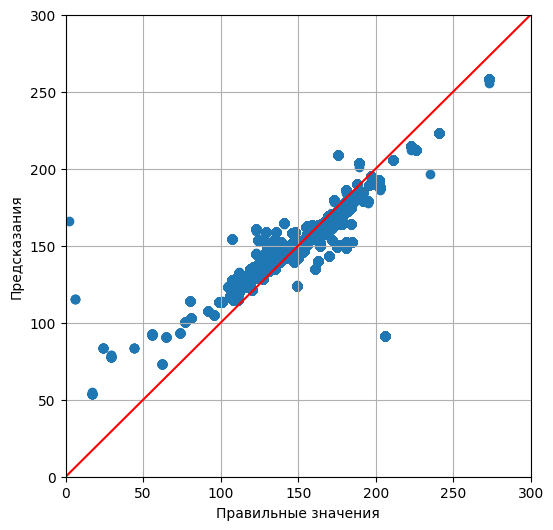

In [ ]:
def eval(model, xTrain, xBOW_text_scaled, yTrain, y_scaler=None, n=5, limit=300):
    plt.style.use('default')

    input_data = [xTrain, xBOW_text_scaled]
    pred = model.predict(input_data)
    if y_scaler:
        pred = y_scaler.inverse_transform(pred)

    print('Первые пять примеров:')
    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))

    start_index = len(yTrain) - 5
    print('Последние пять примеров:')
    for i in range(start_index, len(yTrain)):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))


    start_index = len(yTrain) - 2500
    print('Срез половины примеров:')
    for i in range(start_index, len(yTrain)):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))


    print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(yTrain, pred)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

# Пример использования
eval(model_fin, xTrain, xBOW_text_scaled, yTrain, y_scaler)


In [ ]:
pred = model_fin.predict([xTrain, xBOW_text_scaled])
print('Среднее значение ошибки:')
print(mean_absolute_error(pred, yTrain))

1640/1640 [==============================] - 6s 3ms/step
Среднее значение ошибки:
151.62941454276165


In [ ]:
pred = model_fin.predict(xBOW_text_scaled)
print('Среднее значение ошибки:')
print(mean_absolute_error(pred, yTrain))

1640/1640 [==============================] - 6s 3ms/step
Среднее значение ошибки:
151.66299049885234


In [ ]:
check_MAE_predictl_DubbleInput(model_fin, xTrain, xBOW_text, yTrain, plot=True)

NameError: name 'xTrain' is not defined

In [ ]:
model_fin.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 5000)              20000     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               640128    
                                                                 
 dense_1 (Dense)             (None, 1000)              129000    
                                                                 
 dense_2 (Dense)             (None, 100)               100100    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 889329 (3.39 MB)
Trainable params: 879329 (3.35 MB)
Non-trainable params: 10000 (39.06 KB)
_________________

Для решения задачи требуются знания по теме `Callbacks`, пожалуйста, изучите раздел:

---
Дополнителная информация: ([База знаний УИИ – **«Callbacks»**](https://colab.research.google.com/drive/1COE1R3kFhRlxPm9X6hQMvjKoiFFt83xW?usp=sharing))

---

# Код разбитый по ячейкам

In [ ]:
# Дополнительные библиотеки

!pip install keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, concatenate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [ ]:
# Обучение нормализация данных модели 1

yTrain_reshaped = yTrain.reshape(-1, 1)
y_scaler = StandardScaler()
y_scaler.fit(yTrain_reshaped)
yTrain_scaled = y_scaler.transform(yTrain_reshaped)


model_simple2 = Sequential()
model_simple2.add(BatchNormalization(input_dim=xTrain.shape[1]))
model_simple2.add(Dense(128, activation='relu'))
model_simple2.add(Dense(1000, activation='tanh'))
model_simple2.add(Dense(100, activation='relu'))
model_simple2.add(Dense(1, activation='linear'))

model_simple2.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

In [ ]:
# Обучение модели 2, BOW

scaler = MinMaxScaler()
xBOW_text_scaled = scaler.fit_transform(xBOW_text)


model_simple3 = Sequential()
model_simple3.add(BatchNormalization(input_dim=xBOW_text_scaled.shape[1]))
model_simple3.add(Dense(128, activation='relu'))
model_simple3.add(Dense(1000, activation='tanh'))
model_simple3.add(Dense(100, activation='relu'))
model_simple3.add(Dense(1, activation='linear'))

model_simple3.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

In [ ]:
# Финальная модель

input1 = Input((xTrain.shape[1],))
input2 = Input((xBOW_text_scaled.shape[1],))

x1 = input1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)

model_final_scaled = Model((input1, input2), x)

In [ ]:
# Компиляция модели

model_final_scaled.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final_scaled.fit([xTrain, xBOW_text_scaled],
                           yTrain_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1)

Epoch 1/50
175/175 [==============================] - 17s 22ms/step - loss: 0.7927 - mae: 0.6060 - val_loss: 0.7905 - val_mae: 0.6546
Epoch 2/50
175/175 [==============================] - 2s 9ms/step - loss: 0.3354 - mae: 0.3575 - val_loss: 0.8775 - val_mae: 0.6672
Epoch 3/50
175/175 [==============================] - 1s 8ms/step - loss: 0.2793 - mae: 0.3203 - val_loss: 0.9277 - val_mae: 0.6931
Epoch 4/50
175/175 [==============================] - 1s 8ms/step - loss: 0.2657 - mae: 0.3116 - val_loss: 0.8500 - val_mae: 0.6645
Epoch 5/50
175/175 [==============================] - 1s 7ms/step - loss: 0.2619 - mae: 0.3064 - val_loss: 0.9304 - val_mae: 0.7019
Epoch 6/50
175/175 [==============================] - 1s 8ms/step - loss: 0.2054 - mae: 0.2756 - val_loss: 0.9219 - val_mae: 0.6838
Epoch 7/50
175/175 [==============================] - 1s 7ms/step - loss: 0.1779 - mae: 0.2576 - val_loss: 0.9310 - val_mae: 0.6791
Epoch 8/50
175/175 [==============================] - 2s 11ms/step - loss:

In [ ]:
# Освобождение памяти от ненужных более объектов
del data_text, tokenizer

1640/1640 [==============================] - 4s 2ms/step

Средняя абсолютная ошибка: 5.209086810531107 



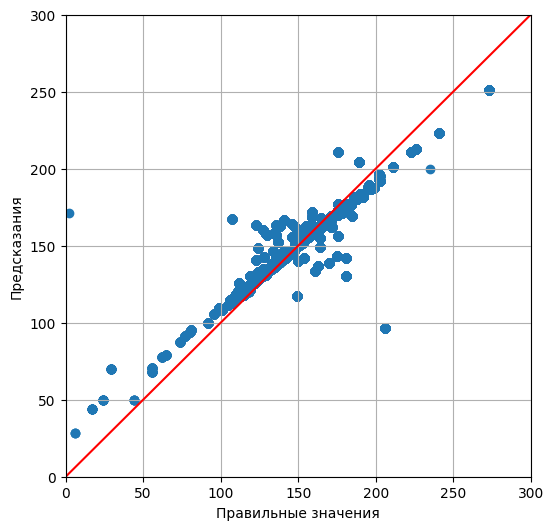

In [ ]:
# Функция оценки результатов и вывода оценки

def eval_net(model, xTrain, yTrain, y_scaler = None, n = 5, limit = 300):
    plt.style.use('default')

    pred = model.predict(xTrain)
    if y_scaler:
        pred = y_scaler.inverse_transform(pred)

    print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(yTrain, pred)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()


eval_net(model_final_scaled, [xTrain, xBOW_text_scaled], yTrain, y_scaler)

# Исследования ошибок

MAE (Mean Absolute Error) представляет собой среднее арифметическое абсолютных значений разностей между фактическими и предсказанными значениями. Формула MAE выглядит следующим образом:

\[ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{\text{факт},i} - y_{\text{пред},i}| \]

Где:
- \( n \) - количество наблюдений (или элементов) в данных.
- \( y_{\text{факт},i} \) - фактическое значение для i-го наблюдения.
- \( y_{\text{пред},i} \) - предсказанное значение для i-го наблюдения.
- \( \sum_{i=1}^{n} \) - сумма значений от \( i = 1 \) до \( n \).

Таким образом, для каждого наблюдения мы вычисляем абсолютное значение разности между фактическим и предсказанным значением, затем берем среднее значение этих абсолютных разностей для всего набора данных.

MAE измеряет среднюю величину ошибки между фактическими и предсказанными значениями и предоставляет представление о том, насколько сильно модель ошибается в среднем.

In [ ]:
pred = model_fin.predict([xTrain, xBOW_text_scaled])
print('Среднее значение ошибки:')
print(mean_absolute_error(pred, yTrain))

1640/1640 [==============================] - 6s 4ms/step
Среднее значение ошибки:
151.62896325194245


1640/1640 [==============================] - 3s 2ms/step
Среднаяя абслолютная ошибка 151.629 очков это 100.002% от общей выборки в 52450 игры


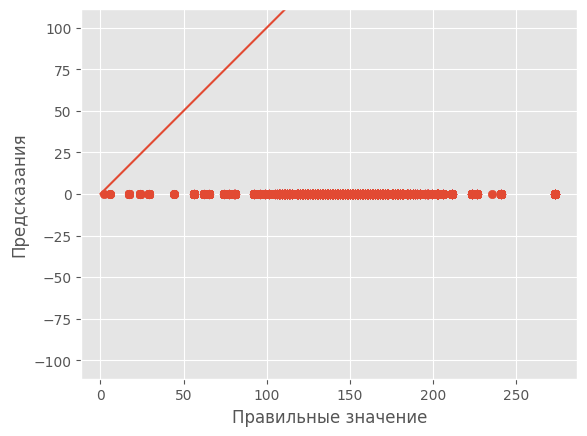

In [ ]:
#функция средней ошибки заданная в условиях дз

check_MAE_predictl_DubbleInput(model_fin, xTrain, xBOW_text, yTrain, plot=True)

1640/1640 [==============================] - 3s 2ms/step

Средняя абсолютная ошибка: 18.270579102027973 

Реальное значение:  81.00  Предсказанное значение: 151.55  Разница:  70.55
Реальное значение:  81.00  Предсказанное значение: 151.55  Разница:  70.55
Реальное значение:  81.00  Предсказанное значение: 151.55  Разница:  70.55
Реальное значение:  81.00  Предсказанное значение: 151.55  Разница:  70.55
Реальное значение:  81.00  Предсказанное значение: 151.55  Разница:  70.55


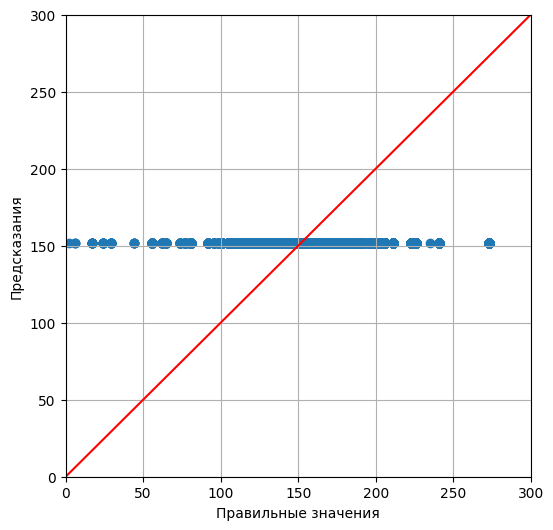

In [ ]:
def eval(model, xTrain, yTrain, y_scaler = None, n = 5, limit = 300):
  plt.style.use('default')

  pred = model.predict(xTrain)
  if y_scaler:
    pred = y_scaler.inverse_transform(pred)

  print('\nСредняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

  for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(yTrain, pred)
  ax.set_xlim(0, limit)
  ax.set_ylim(0, limit)
  ax.plot(plt.xlim(), plt.ylim(), 'r')
  plt.xlabel('Правильные значения')
  plt.ylabel('Предсказания')
  plt.grid()
  plt.show()

eval(model_fin, [xTrain, xBOW_text_scaled], yTrain, y_scaler)

**Из сравнения представленных выше функций видно что, та функция которая написана в условиях задачи показывает предсказание модели, а не среднюю абсолютную ошибку.**

##модель на которой делалось иследование ошибок

In [ ]:
yTrain_reshaped = yTrain.reshape(-1, 1)
y_scaler = StandardScaler()
y_scaler.fit(yTrain_reshaped)
yTrain_scaled = y_scaler.transform(yTrain_reshaped)

scaler = MinMaxScaler()
xBOW_text_scaled = scaler.fit_transform(xBOW_text)

input1 = Input((xTrain.shape[1],))
input2 = Input((xBOW_text_scaled.shape[1],))

x1 = input1
x1 = Dense(20, activation="relu")(x1)
x1 = Dense(500, activation="relu")(x1)
x1 = Dropout(0.3)(x1)

x2 = input2
x2 = Dense(128, activation="relu")(x2)
x2 = Dense(1000, activation="tanh")(x2)
x2 = Dense(100, activation="relu")(x2)

x = concatenate([x1,x2])

x = Dense(15, activation="relu")(x)
x = Dropout(0,5)(x)
x = Dense(1, activation='linear')(x)

model_fin = Model((input1, input2), x)

model_fin.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_fin.fit([xTrain, xBOW_text_scaled],
                        yTrain_scaled,
                        batch_size=256,
                        epochs=50,
                        validation_split=0.15,
                        verbose=1)

# Исследования

In [ ]:
# начальный код

# Загрузка из google облака
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)

# Библиотека для работы с базами
import pandas as pd
df = pd.read_csv('basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) # Загружаем базу
# df.head()

data_text = df['info'].values
# len(data_text) #длина списка


# Импортируем токенайзер
!pip install keras
from tensorflow.keras.preprocessing.text import Tokenizer

maxWordsCount = 5000

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount,
                       filters=sim_for_del,
                       lower=True,
                       split=' ',
                       oov_token='unknown',
                       char_level=False)

tokenizer.fit_on_texts(data_text)


# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)


# Библиотека работы с массивами
import numpy as np

xTrain = np.array(df[['Ком. 1','Ком. 2', 'Минута', 'Секунда','ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))

In [ ]:
# График
def plot_history(history):
    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Средняя абсолютная ошибка (обучение)', color='blue')
    plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка (проверка)', color='orange')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.title('История обучения модели')
    plt.legend()
    plt.show()

In [ ]:
# Обучение модели на простых данных
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


model_simple1 = Sequential()
model_simple1.add(BatchNormalization(input_dim=xTrain.shape[1]))
model_simple1.add(Dense(128, activation='relu'))
model_simple1.add(Dense(1000, activation='tanh'))
model_simple1.add(Dense(100, activation='relu'))
model_simple1.add(Dense(1, activation='linear'))

model_simple1.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

# history = model_simple1.fit(xTrain,
#                     yTrain,
#                     epochs=2,
#                     batch_size=256,
#                     validation_split=0.15,
#                     verbose=1)

# plot_history(history)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple1.predict(xTrain)

# # Расчет среднего значения ошибки
# print((abs(pred - yTrain)).mean())         # Расчет вручную
print('Среднее значение ошибки:')
print(mean_absolute_error(pred, yTrain))   # Расчет с помощью готовой функции

1640/1640 [==============================] - 5s 2ms/step
Среднее значение ошибки:
153.44247554360854


In [ ]:
# Функция оценки результатов и вывода оценки

def eval_net(model, xTrain, yTrain, y_scaler = None, n = 5, limit = 1000):
    plt.style.use('default')

    pred = model.predict(xTrain)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)
        print('денормирование yTrain')

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, yTrain), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(yTrain[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(yTrain[i] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(yTrain, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

1640/1640 [==============================] - 7s 4ms/step
Средняя абсолютная ошибка: 153.44247554360854 

Реальное значение:  81.00  Предсказанное значение:  -1.67  Разница:  82.67
Реальное значение:  81.00  Предсказанное значение:  -1.79  Разница:  82.79
Реальное значение:  81.00  Предсказанное значение:  -1.36  Разница:  82.36
Реальное значение:  81.00  Предсказанное значение:  -1.73  Разница:  82.73
Реальное значение:  81.00  Предсказанное значение:  -1.43  Разница:  82.43


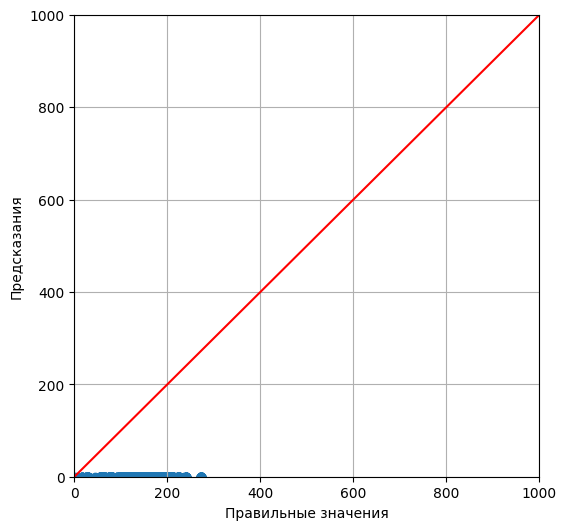

In [ ]:
eval_net(model_simple1, xTrain, yTrain)

In [ ]:
print(yTrain)
print(yTrain.shape)

[ 81  81  81 ... 170 170 170]
(52450,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Пример одномерного массива
# yTrain = np.array([81, 82, 83, 84, 85])

# Изменяем форму массива
yTrain_reshaped = yTrain.reshape(-1, 1)

# Создаем и применяем StandardScaler
y_scaler = StandardScaler()
y_scaler.fit(yTrain_reshaped)  # Вычисляем среднее и стандартное отклонение

# Применяем трансформацию
yTrain_scaled = y_scaler.transform(yTrain_reshaped)



# Возвращаем к одномерному виду (если это необходимо)
# yTrain_scaled = yTrain_scaled.flatten()


In [ ]:
# Проверка нормализации
print(yTrain_scaled.shape)
print(f'Оригинальное значение:  {yTrain_reshaped[1, 0]}')
print(f'Нормированное значение: {yTrain_scaled[1, 0]}')

# Вывод границ ненормализованных и нормализованных данных
print(yTrain_reshaped.mean(), yTrain_reshaped.std())
print(yTrain_scaled.mean(), yTrain_scaled.std())

(52450, 1)
Оригинальное значение:  81
Нормированное значение: -2.8372177369594733
151.62581506196378 24.8926313063482
-9.862251890054394e-17 1.0


In [ ]:
yTrain_scaled.min(), yTrain_scaled.max()

(-6.0108476769912915, 4.87590819324444)

In [ ]:
print(xTrain.shape)
print(yTrain_scaled.shape)


(52450, 5)
(52450, 1)


In [ ]:

# Обучение модели на простых данных с нормализованными данными
model_simple2 = Sequential()
model_simple2.add(BatchNormalization(input_dim=xTrain.shape[1]))
model_simple2.add(Dense(128, activation='relu'))
model_simple2.add(Dense(1000, activation='tanh'))
model_simple2.add(Dense(100, activation='relu'))
model_simple2.add(Dense(1, activation='linear'))

model_simple2.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

# history = model_simple2.fit(xTrain,
#                     yTrain_scaled,
#                     epochs=50,
#                     batch_size=256,
#                     validation_split=0.15,
#                     verbose=1)

# plot_history(history)

In [ ]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple2.predict(xTrain)
print('Среднее значение ошибки:')
print(mean_absolute_error(pred, yTrain_scaled))   # Расчет с помощью готовой функции

1640/1640 [==============================] - 7s 4ms/step
Среднее значение ошибки:
1.3277597148179443


1640/1640 [==============================] - 3s 2ms/step
денормирование yTrain
Средняя абсолютная ошибка: 33.0514331173965 

Реальное значение:  81.00  Предсказанное значение: 179.01  Разница:  98.01
Реальное значение:  81.00  Предсказанное значение: 179.39  Разница:  98.39
Реальное значение:  81.00  Предсказанное значение: 182.94  Разница: 101.94
Реальное значение:  81.00  Предсказанное значение: 177.90  Разница:  96.90
Реальное значение:  81.00  Предсказанное значение: 181.99  Разница: 100.99


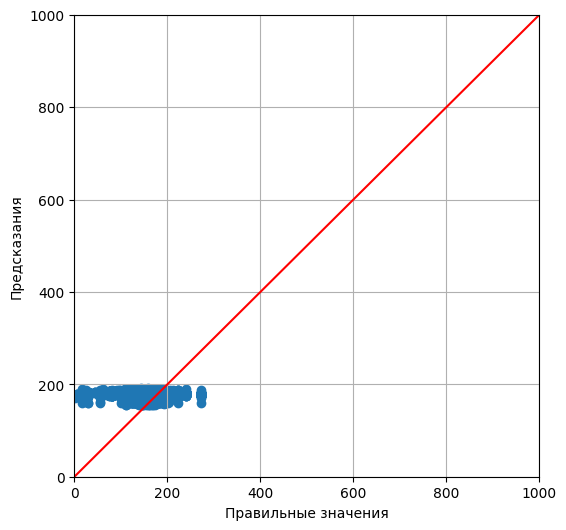

In [ ]:
eval_net(model_simple2, xTrain, yTrain, y_scaler)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Нормализуем входные данные
scaler = MinMaxScaler()
xBOW_text_scaled = scaler.fit_transform(xBOW_text)

# Обучение модели на простых данных с нормализованными данными
model_simple3 = Sequential()
model_simple3.add(BatchNormalization(input_dim=xBOW_text_scaled.shape[1]))
model_simple3.add(Dense(128, activation='relu'))
model_simple3.add(Dense(1000, activation='tanh'))
model_simple3.add(Dense(100, activation='relu'))
model_simple3.add(Dense(1, activation='linear'))

model_simple3.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

# history = model_simple3.fit(xBOW_text_scaled,
#                     yTrain_scaled,
#                     epochs=50,
#                     batch_size=256,
#                     validation_split=0.15,
#                     verbose=1)

# plot_history(history)

In [ ]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple3.predict(xBOW_text_scaled)
print('Среднее значение ошибки:')
print(mean_absolute_error(pred, yTrain_scaled))   # Расчет с помощью готовой функции

1640/1640 [==============================] - 7s 4ms/step
Среднее значение ошибки:
0.20119295430008333


1640/1640 [==============================] - 6s 4ms/step
денормирование yTrain
Средняя абсолютная ошибка: 5.008221945076244 

Реальное значение:  81.00  Предсказанное значение:  77.46  Разница:   3.54
Реальное значение:  81.00  Предсказанное значение:  77.46  Разница:   3.54
Реальное значение:  81.00  Предсказанное значение:  77.46  Разница:   3.54
Реальное значение:  81.00  Предсказанное значение:  77.46  Разница:   3.54
Реальное значение:  81.00  Предсказанное значение:  77.46  Разница:   3.54


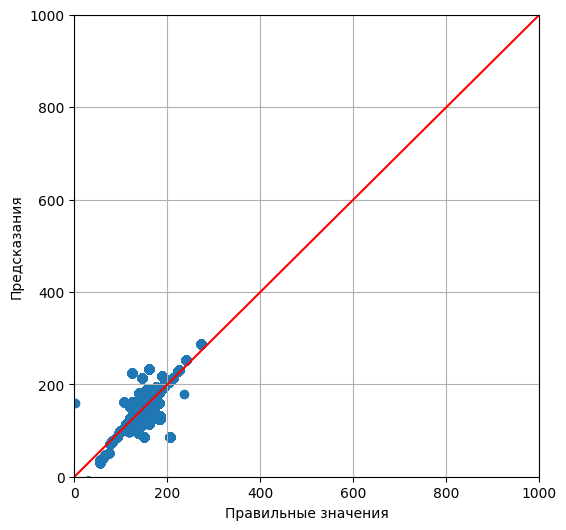

In [ ]:
eval_net(model_simple3, xBOW_text_scaled, yTrain, y_scaler)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, concatenate

input1 = Input((xTrain.shape[1],))
input2 = Input((xBOW_text_scaled.shape[1],))
# input3 = Input(xBOW_text_scaled.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

# x3 = input3                               # Ветка 3
# x3 = Dense(30, activation="relu")(x3)
# x3 = Dense(800, activation="relu")(x3)
# x3 = Dropout(0.3)(x3)

x = concatenate([x1, x2])
# x = concatenate([x1, x2, x3])             # Объединение трех веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
# model_final = Model((input1, input2, input3), x)
model_final_scaled = Model((input1, input2), x)

In [ ]:
!pip install keras

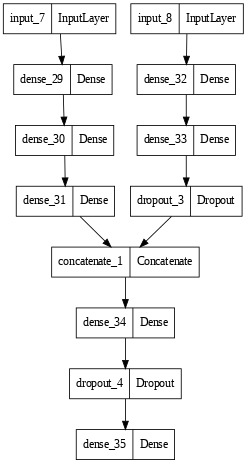

In [ ]:
from tensorflow.keras import utils

utils.plot_model(model_final_scaled, dpi=60)

In [ ]:
model_final_scaled.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final_scaled.fit([xTrain, xBOW_text_scaled],
                           yTrain_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1)

Epoch 1/50
175/175 [==============================] - 8s 12ms/step - loss: 0.7134 - mae: 0.5570 - val_loss: 0.8526 - val_mae: 0.6746
Epoch 2/50
175/175 [==============================] - 1s 7ms/step - loss: 0.3643 - mae: 0.3495 - val_loss: 0.9054 - val_mae: 0.6871
Epoch 3/50
175/175 [==============================] - 2s 9ms/step - loss: 0.3006 - mae: 0.3387 - val_loss: 0.9541 - val_mae: 0.6962
Epoch 4/50
175/175 [==============================] - 1s 8ms/step - loss: 0.2206 - mae: 0.2887 - val_loss: 0.9402 - val_mae: 0.7003
Epoch 5/50
175/175 [==============================] - 1s 7ms/step - loss: 0.1844 - mae: 0.2607 - val_loss: 0.9951 - val_mae: 0.7027
Epoch 6/50
175/175 [==============================] - 2s 13ms/step - loss: 0.1780 - mae: 0.2524 - val_loss: 0.9659 - val_mae: 0.7039
Epoch 7/50
175/175 [==============================] - 1s 8ms/step - loss: 0.1740 - mae: 0.2474 - val_loss: 0.9720 - val_mae: 0.7016
Epoch 8/50
175/175 [==============================] - 1s 8ms/step - loss: 

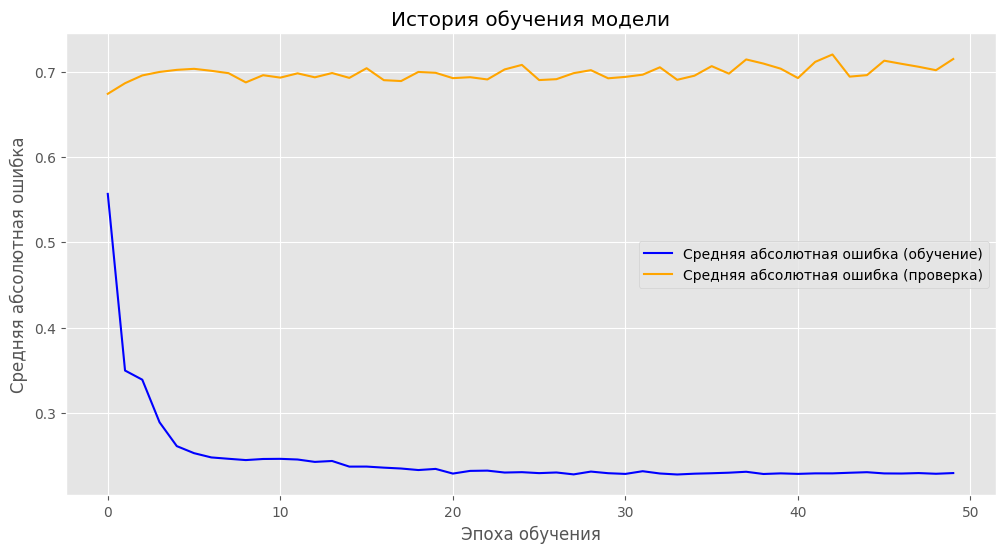

In [ ]:
plot_history(history)

1640/1640 [==============================] - 3s 2ms/step
денормирование yTrain
Средняя абсолютная ошибка: 4.703785368971193 

Реальное значение:  81.00  Предсказанное значение:  94.89  Разница:  13.89
Реальное значение:  81.00  Предсказанное значение:  94.89  Разница:  13.89
Реальное значение:  81.00  Предсказанное значение:  94.89  Разница:  13.89
Реальное значение:  81.00  Предсказанное значение:  94.89  Разница:  13.89
Реальное значение:  81.00  Предсказанное значение:  94.89  Разница:  13.89


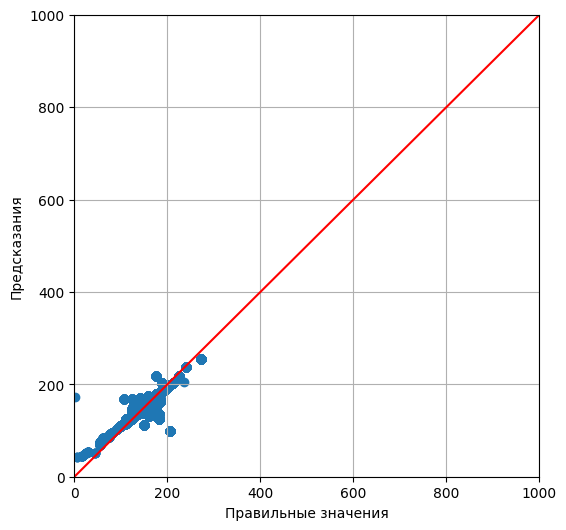

In [ ]:
eval_net(model_final_scaled, [xTrain, xBOW_text_scaled], yTrain, y_scaler)

# Первые исследования

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback

pltMae = LambdaCallback(on_epoch_end_custom=on_epoch_end_custom)

# Функция по проверке финальной ошибки
def check_MAE_predictl_DubbleInput (model_final_scaled,
                                    xTrain,
                                    xBOW_text_scaled,
                                    yTrain,
                                    plot=False):

  mae = 0 # Инициализируем начальное значение ошибки
  y_pred = (model_final_scaled.predict([xTrain,xBOW_text_scaled])).squeeze()

  for n in range (0,len(xTrain)):
    mae += abs(yTrain[n] - y_pred[n]) # Увеличиваем значение ошибки для текущего элемента
  mae /= len(xTrain) # Считаем среднее значение
  print('Среднаяя абслолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры'.format(mae, (mae/yTrain.mean(axis=0))*100,len(xTrain)))

  if plot:
     plt.scatter(yTrain, y_pred)
     plt.xlabel('Правильные значение')
     plt.ylabel('Предсказания')
     plt.axis('equal')
     plt.xlim(plt.xlim())
     plt.ylim(plt.ylim())
     plt.plot([0, 250], [0, 250])
     plt.show()

# Финальный коллбек
def on_epoch_end_custom(epoch, logs=None):
    check_MAE_predictl_DubbleInput(model_final_scaled, xTrain, xBOW_text, yTrain, plot=True)

pltMae = LambdaCallback(on_epoch_end_custom=on_epoch_end_custom)
pltMae

In [ ]:
# Освобождение памяти от ненужных более объектов
del exp_text, exp_seq, tokenizer

In [ ]:
# Освобождение памяти
del model_simple, model_prof, model_exp

In [ ]:
# Импорт библиотек
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import gdown
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer
# Библиотека работы с массивами
import numpy as np

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)

# Библиотека для работы с базами
import pandas as pd
df = pd.read_csv('basketball.csv', encoding='cp1251', sep=';', header=0, index_col=0)  # Загружаем базу
df.head()

data_text = df['info'].values
len(data_text)  # длина списка



maxWordsCount = 5000

sim_for_del = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters=sim_for_del,
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(data_text)

# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

# Библиотека работы с массивами
import numpy as np

xTrain = np.array(df[['Ком. 1', 'Ком. 2', 'Минута', 'Секунда', 'ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))







# Обучение модели 1
model_exp = Sequential()
model_exp.add(Dense(30, activation='relu', input_dim=xTrain.shape[1]))
model_exp.add(Dense(800, activation='relu'))
model_exp.add(Dropout(0.3))
model_exp.add(Dense(1, activation='linear'))

model_exp.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])

history = model_exp.fit(xTrain,
                        yTrain,
                        batch_size=256,
                        epochs=2,
                        validation_split=0.15,
                        verbose=1)




# Определяем Коллбэк
def on_epoch_end(epoch, logs):
    print(epoch, logs)

    # Предсказания модели на xTrain и xBOW_text
    pred = model_exp.predict(xTrain)

    # Ваша логика вычисления ошибки или других метрик
    your_custom_metric = 2  # Вам нужно дописать логику вашей метрики

    print("Epoch", epoch, "Your custom metric:", your_custom_metric)

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)


history_final = model_exp.fit(xTrain, yTrain,
                              epochs=2,
                              validation_split=0.15,
                              verbose=0,
                              callbacks=[pltMae])






Epoch 1/2
175/175 [==============================] - 2s 8ms/step - loss: 5466.6685 - mae: 59.5595 - val_loss: 2844.4985 - val_mae: 41.1276
Epoch 2/2
175/175 [==============================] - 1s 7ms/step - loss: 2977.0876 - mae: 42.9360 - val_loss: 2529.4458 - val_mae: 38.7491
0 {'loss': 2239.912353515625, 'mae': 37.30092239379883, 'val_loss': 1317.57666015625, 'val_mae': 28.66782569885254}
1640/1640 [==============================] - 2s 1ms/step
Epoch 0 Your custom metric: 2
1 {'loss': 1192.1011962890625, 'mae': 27.118457794189453, 'val_loss': 571.0108032226562, 'val_mae': 18.607086181640625}
1640/1640 [==============================] - 2s 1ms/step
Epoch 1 Your custom metric: 2


In [ ]:
# Функция по проверке ошибки
def check_MAE_predictl_DubbleInput(model, x_data, x_data_text, y_data_not_scaled, plot=False):
    mae = 0  # Инициализируем начальное значение ошибки
    y_pred = (model.predict([x_data, x_data_text])).squeeze()

    for n in range(0, len(x_data)):
        mae += abs(y_data_not_scaled[n] - y_pred[n])  # Увеличиваем значение ошибки для текущего элемента
    mae /= len(x_data)  # Считаем среднее значение
    print('Среднаяя абсолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры'.format(mae,
                                                                                                (mae / y_data_not_scaled.mean(
                                                                                                    axis=0)) * 100,
                                                                                                len(x_data)))

    if plot:
        plt.scatter(y_data_not_scaled, y_pred)
        plt.xlabel('Правильные значение')
        plt.ylabel('Предсказания')
        plt.axis('equal')
        plt.xlim(plt.xlim())
        plt.ylim(plt.ylim())
        plt.plot([0, 250], [0, 250])
        plt.show()


def on_epoch_end_custom(epoch, logs=None):
    check_MAE_predictl_DubbleInput(model_exp, xTrain, xBOW_text, yTrain, plot=True)
    # check_MAE_predictl_DubbleInput(model_final_scaled, xTrain_scaled, xBOW_text, yTrain, plot=True)

In [ ]:
# Обучение модели 1 (на данных об опыте работы (должности))
history = model_exp.fit(xTrain,
                        yTrain,
                        batch_size=256,
                        epochs=2,
                        validation_split=0.15,
                        verbose=1)

# Вызов функции для отображения ошибки
check_MAE_predictl_DubbleInput(model_exp, xTrain, xBOW_text, yTrain, plot=True)


Epoch 1/2
175/175 [==============================] - 3s 9ms/step - loss: 5467.8599 - mae: 59.6089 - val_loss: 2573.5500 - val_mae: 38.9234
Epoch 2/2
1640/1640 [==============================] - 2s 1ms/step
Средняя абсолютная ошибка: 39615.00891495768 

Реальное значение:   0.29  Предсказанное значение: 30085.04  Разница: 30084.75
Реальное значение:   0.29  Предсказанное значение: 43364.25  Разница: 43363.96
Реальное значение:   0.29  Предсказанное значение: 6277.20  Разница: 6276.91
Реальное значение:   0.29  Предсказанное значение: 30176.93  Разница: 30176.64
Реальное значение:   0.29  Предсказанное значение: 7502.96  Разница: 7502.67


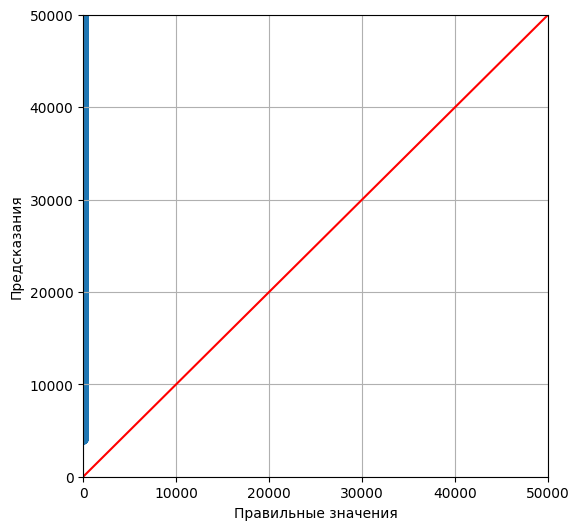

In [ ]:
# Импорт библиотек
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import gdown
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer
# Библиотека работы с массивами
import numpy as np
# Библиотека для работы с базами
import pandas as pd


gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)
df = pd.read_csv('basketball.csv', encoding='cp1251', sep=';', header=0, index_col=0)  # Загружаем базу
df.head()

data_text = df['info'].values
len(data_text)  # длина списка


maxWordsCount = 5000
sim_for_del = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters=sim_for_del,
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(data_text)

# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант Bag of Words
# xBOW_text = tokenizer.sequences_to_matrix(Sequences)

xTrain = np.array(df[['Ком. 1', 'Ком. 2', 'Минута', 'Секунда', 'ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))


from sklearn.preprocessing import MinMaxScaler

# Создание и обучение scaler на тренировочных данных
y_scaler = MinMaxScaler()
y_scaler.fit(yTrain.reshape(-1, 1))
# Масштабирование целевой переменной
yTrain_scaled = y_scaler.transform(yTrain.reshape(-1, 1)).flatten()


# Коллбэк
def on_epoch_end(epoch, logs):
    print(epoch, logs)
    # Предсказания модели на xTrain и xBOW_text
    pred = model_exp.predict(xTrain)
    # Логика вычисления ошибки или других метрик
    your_custom_metric = 2  # Дописать логику метрики
    print("Epoch", epoch, "Your custom metric:", your_custom_metric)
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)


# Функция оценки результатов и вывода оценки
def eval_net(model, x_train, y_train, y_scaler=None, n=5, limit=1000):
    plt.style.use('default')

    pred = model.predict(x_train)  # Предсказание на тренировочной выборке
    if y_scaler:  # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)
        # print('денормирование y_train')

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(min(n, len(y_train))):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)  # Отрисовка точечного графика
    ax.set_xlim(0, 50000)  # Пределы по x, y
    ax.set_ylim(0, 50000)
    # ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')  # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()


# Обучение модели 1
model_exp = Sequential()
model_exp.add(Dense(30, activation='relu', input_dim=xTrain.shape[1]))
model_exp.add(Dense(800, activation='relu'))
model_exp.add(Dropout(0.3))
model_exp.add(Dense(1, activation='linear'))

model_exp.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])

history = model_exp.fit(xTrain,
                        yTrain,
                        batch_size=256,
                        epochs=2,
                        validation_split=0.15,
                        verbose=1)


# Оценка результатов после обучения
eval_net(model_exp, xTrain, yTrain_scaled, y_scaler)




# history_final = model_exp.fit(xTrain, yTrain,
#                               epochs=2,
#                               validation_split=0.15,
#                               verbose=0,
#                               callbacks=[pltMae])


In [ ]:
# Импорт библиотек
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import gdown
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer
# Библиотека работы с массивами
import numpy as np
# Библиотека для работы с базами
import pandas as pd

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)
df = pd.read_csv('basketball.csv', encoding='cp1251', sep=';', header=0, index_col=0)  # Загружаем базу
# df.head(100)

In [ ]:
data_text = df['fcount'].values
len(data_text)  # длина списка

52450

In [ ]:
data_text = df['Секунда'].values
len(data_text)  # длина списка

52450

In [ ]:
df.summary()

In [ ]:





maxWordsCount = 5000
sim_for_del = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters=sim_for_del,
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(data_text)

# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант Bag of Words
# xBOW_text = tokenizer.sequences_to_matrix(Sequences)

xTrain = np.array(df[['Ком. 1', 'Ком. 2', 'Минута', 'Секунда', 'ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))

## Сохранение данных в Numpy массивы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Сохранение массивов в файлы NumPy array
# np.save('/content/drive/MyDrive/x_train_01.npy', x_train_01)
# np.save('/content/drive/MyDrive/y_train.npy', y_train)

In [ ]:
import numpy as np

# Загрузка массивов из файлов
x_train_01 = np.load('/content/drive/MyDrive/x_train_01.npy')
y_train = np.load('/content/drive/MyDrive/y_train.npy')

# Вывод загруженных массивов
print("Массив x_train_01:")
print(x_train_01.shape)
print("\nМассив y_train:")
print(y_train.shape)


Массив x_train_01:
(62967, 39)

Массив y_train:
(62967, 1)


**Функция отрисовки графика истории обучения**

In [ ]:
def plot_history(history):
    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Средняя абсолютная ошибка (обучение)', color='blue')
    plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка (проверка)', color='orange')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.title('История обучения модели')
    plt.legend()
    plt.show()